### Contributor: Ray, Yu, Joshua, Hang

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
data_one = pd.read_csv("clickstreams_with_purchase.csv")
data_two = pd.read_csv("clickstreams_without_purchase.csv")
a = data_one.groupby("customer_id").size().reset_index(name='counts')
ID1 = a[a["counts"]>200]["customer_id"].unique()
a = data_two.groupby("customer_id").size().reset_index(name='counts')
ID2 = a[a["counts"]>200]["customer_id"].unique()

In [4]:
seqs_one = []
for i in range(len(ID1)):
    if i%10000 == 0:
        print(i)
    sub = data_one[data_one["customer_id"] == ID1[i]]
    sub = sub.sort_values(["date", "time"])
    time = sub["date"].unique()
    if len(time) != 0:
        for i in range(len(time)):
            subb = sub[sub["date"] == time[i]]
            ss = list(subb["page_viewed"])
            if len(ss) > 50:
                seqs_one.append(ss)
    else:
        ss = list(sub["page_viewed"])
        if len(ss) > 50:
            seqs_one.append(ss)

0
10000


In [5]:
seqs_two = []
for i in range(len(ID2)):
    if i%1000 == 0:
        print(i)
    sub = data_two[data_two["customer_id"] == ID2[i]]
    sub = sub.sort_values(["date", "time"])
    time = sub["date"].unique()
    if len(time) != 0:
        for i in range(len(time)):
            subb = sub[sub["date"] == time[i]]
            ss = list(subb["page_viewed"])
            if len(ss) > 50:
                seqs_two.append(ss)
    else:
        ss = list(sub["page_viewed"])
        if len(ss) > 50:
            seqs_two.append(ss)

0
1000
2000
3000
4000


In [ ]:
pages = data_one["page_viewed"].unique()
pages_dict = {}
for i in range(len(pages)):
    pages_dict[pages[i]] = i

In [6]:
SEQ = [seqs_one[i][:100] for i in range(len(seqs_one))] + [seqs_two[i][:100] for i in range(len(seqs_two))]
SEQs = []
for i in range(len(SEQ)):
    for j in range(0, len(SEQ[i])-21,5):
        SEQs.append(SEQ[i][j:j+21])
for i in range(len(SEQs)):
    for j in range(21):
        SEQs[i][j] = pages_dict[SEQs[i][j]]
SEQs = np.array(SEQs).reshape((1, 489938*21))[0]
SEQs = to_categorical(SEQs)
SEQs = SEQs.reshape(int(len(SEQs)/21),21, 25)

In [77]:
X = []
Y = []
for i in range(len(SEQs)):
    X.append(list(SEQs[i][:20]))
    Y.append(list(SEQs[i][-1]))
X = np.array(X)
Y = np.array(Y)

ntrain = int(len(X)*0.8)
ntest = int(len(X)*0.9)
train_x, train_y = X[:ntrain], Y[:ntrain]
valid_x, valid_y = X[ntrain:ntest], Y[ntrain:ntest]
test_x, test_y = X[ntest:], Y[ntest:]

In [87]:
model = Sequential()
early_stopping_monitor = EarlyStopping(patience=2)
#model.add(LSTM(16,input_shape=(None, 25),return_sequences=True))
model.add(LSTM(32,input_shape=(None, 25),return_sequences=False))
model.add(Dense(25, activation = 'softmax'))
history = model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=3, batch_size=72, validation_data=(valid_x, valid_y), callbacks=[early_stopping_monitor], shuffle = True)

Train on 391950 samples, validate on 48994 samples
Epoch 1/3
391950/391950 [==============================] - 132s - loss: 1.1890 - acc: 0.6835 - val_loss: 1.0598 - val_acc: 0.7120
Epoch 2/3
391950/391950 [==============================] - 131s - loss: 1.0776 - acc: 0.7059 - val_loss: 1.0339 - val_acc: 0.7132
Epoch 3/3
391950/391950 [==============================] - 131s - loss: 1.0621 - acc: 0.7079 - val_loss: 1.0214 - val_acc: 0.7140


In [101]:
lst_pred = model.predict(test_x)
lst_true = test_y
pred = []
true = []
for i in range(len(lst_pred)):
    pred.append(np.argmax(lst_pred[i]))

for i in range(len(lst_true)):
    true.append(np.argmax(lst_true[i]))

In [107]:
cm = confusion_matrix(true, pred)
acc = accuracy_score(true, pred)
acc

0.7204351553251419

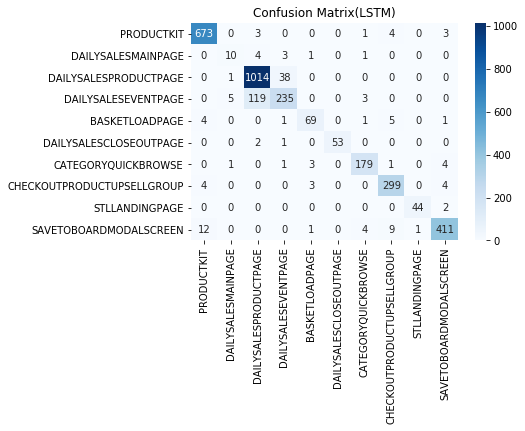

In [132]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
mp2 = list(pages_dict.keys())[15:25]

confusion = pd.DataFrame(cm[15:25,15:25], index=mp2, columns=mp2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
sn.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix(LSTM)")
plt.savefig("Confusion Matrix.jpg", dpi = 600, bbox_inches = 'tight')
plt.show()